In [4]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [5]:
connection = {'host': '***',
                      'database':'***',
                      'user':'***', 
                      'password':'***'
                     }

#### Сформировать подвыборки из 2 и 3 групп

In [6]:
query_group_2 = """
 SELECT distinct user_id, sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
 FROM {db}.feed_actions 
 WHERE toDate(time) >= '2022-12-25' and  toDate(time) <= '2022-12-31' 
     and exp_group in (2)
 GROUP BY user_id
 """

query_group_3 = """
 SELECT distinct user_id, sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
 FROM {db}.feed_actions 
 WHERE toDate(time) >= '2022-12-25' and  toDate(time) <= '2022-12-31' 
     and exp_group in (3)
 GROUP BY user_id
 """


df_group_2 = ph.read_clickhouse(query_group_2, connection=connection)
df_group_3 = ph.read_clickhouse(query_group_3, connection=connection)

#### Провести 10000 АА-тестов для выборок из 500 юзеров

In [7]:
p_values = []
n = 500
k = 10000
for i in range(k):
    p_values.append(stats.ttest_ind(df_group_2.sample(n).ctr,
                df_group_3.sample(n).ctr,
                equal_var=False).pvalue)
    

#### Построить гистограмму распределений p-value

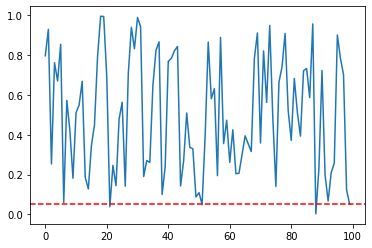

In [33]:
ax = sns.lineplot(data = p_values[0:100])
ax.axhline(0.05, ls='--', color='red')

(array([ 966.,  969.,  967., 1028.,  994., 1074.,  953., 1002., 1018.,
        1029.]),
 array([3.25697227e-04, 1.00282709e-01, 2.00239722e-01, 3.00196734e-01,
        4.00153746e-01, 5.00110758e-01, 6.00067770e-01, 7.00024782e-01,
        7.99981794e-01, 8.99938807e-01, 9.99895819e-01]),
 <a list of 10 Patch objects>)

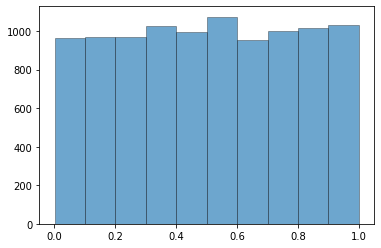

In [34]:
plt.hist(p_values, alpha=0.65, edgecolor='black', linewidth=0.5)

#### Какой процент p values оказался меньше либо равен 0.05

In [35]:
part_of = int(pd.DataFrame(p_values, columns=['p_values']).loc[lambda a: a['p_values'] <= 0.05, :].count()) / int(pd.DataFrame(p_values).count()) * 100
print("{0} % значений p-values оказались меньше либо равно 0.05".format(part_of))

4.71 % значений p-values оказались меньше либо равно 0.05


#### Вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

1) В случае равенства нулевой гипотезы распределение значений p-value будет равномерным (что подтверждается полученным графиком распределения значений p-value).

2) Большое число значений p-value, которые > 0.05, характеризует, что различия между выборочными данными произошли случайно, а разница между сравниваемыми выборками статистически не значима. Таким образом, нет основания отвергнуть нулевую гипотезу (равенство средних сравниваемых выборок).

#### Визуальное сравнение выборок

(array([  3.,  21., 113., 171.,  94.,  57.,  24.,   9.,   7.,   1.]),
 array([0.        , 0.05714286, 0.11428571, 0.17142857, 0.22857143,
        0.28571429, 0.34285714, 0.4       , 0.45714286, 0.51428571,
        0.57142857]),
 <a list of 10 Patch objects>)

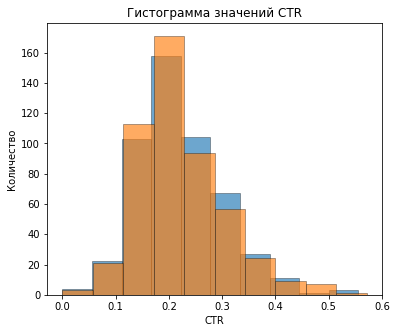

In [37]:
plt.figure(figsize=(6,5))
plt.ylabel('Количество')
plt.xlabel('CTR')
plt.title('Гистограмма значений CTR')
plt.hist(df_group_2.sample(n).ctr,   alpha=0.65, edgecolor='black', linewidth=0.5)
plt.hist(df_group_3.sample(n).ctr,   alpha=0.65, edgecolor='black', linewidth=0.5)